Here we are basically dealing with shapefiles (.shp). It helps us a lot to load geometry data since data is stored with spatial index and divided in multiple files. We dont need to know what it exactly is, but you can check it out later: https://en.wikipedia.org/wiki/Shapefile

For now we can use data constrained to Manhattan. So, just unzip this at 

    tar -xzf path/to/project/data.tar.gz
    
In case you wanna work with the full datasets:

Tree data--* https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35/data
Shapefiles--* https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nynta_17a.zip
Streets--* https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27b/data


### Some tricks to make it easier to reload the modules while coding

In [2]:
import geopandas as gpd
# villagesorig = gpd.GeoDataFrame.from_file('data/nynta_17a/nynta.shp', driver='ESRI Shapefile')

IOError: no such file or directory: 'data/nynta_17a/nynta.shp'

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Loading base modules 

In [4]:
%reload_ext autoreload
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]

### Loading datasets

In [5]:
from functools import partial
import pyproj
from shapely.ops import transform

#these are the datasets we are working with
villages = gpd.GeoDataFrame.from_file('data/villages-mn.shp', driver='ESRI Shapefile')
streets = gpd.read_file('data/streets-mn.shp', driver='ESRI Shapefile')
trees = gpd.read_file('data/trees-mn.shp', driver='ESRI Shapefile')

### Converting CRS to UTM ( "flat" the maps, thus spatial queries get much easier)

In [6]:
villages = villages.to_crs(epsg=26918)
streets = streets.to_crs(epsg=26918)
trees = trees.to_crs(epsg=26918)

In [7]:
len(villages)

29

In [8]:
from datetime import datetime

m = trees.created_at

def get_date(x):
    dt = datetime.strptime(x, '%m/%d/%Y')
    return dt

trees['created_custom'] = trees.created_at.apply(lambda x: get_date(x))

In [9]:
t = trees.created_custom
print t.min(), t.max()

2015-05-19 00:00:00 2016-10-03 00:00:00


### Let's plot some trees and streets in MN borough 

as an example, let's quick sample each dataset (saving some time) 

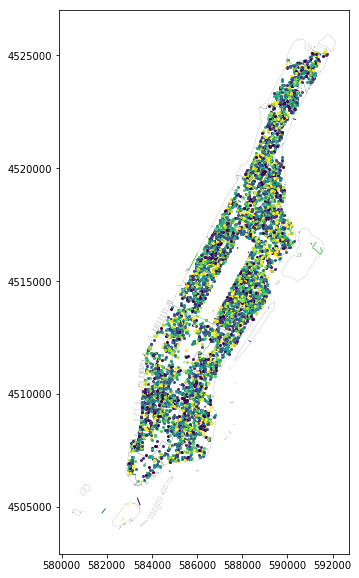

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
villages.sample(29).plot(ax=ax, color="white", linewidth=.1)
trees.sample(6500).plot(ax=ax)
streets.sample(100).plot(ax=ax)
#villages

### What are the columns of these dataset?

In [11]:
trees.head()
trees.columns
#villages

Index([       u'address',       u'block_id',        u'boro_ct',
             u'borocode',       u'boroname',     u'brnch_ligh',
           u'brnch_othe',     u'brnch_shoe',         u'cb_num',
             u'cncldist',     u'created_at',       u'curb_loc',
             u'geometry',         u'guards',         u'health',
             u'latitude',      u'longitude',            u'nta',
             u'nta_name',       u'problems',     u'root_grate',
           u'root_other',     u'root_stone',       u'sidewalk',
           u'spc_common',      u'spc_latin',       u'st_assem',
            u'st_senate',          u'state',         u'status',
              u'steward',     u'stump_diam',       u'tree_dbh',
              u'tree_id',     u'trnk_light',     u'trnk_other',
            u'trnk_wire',      u'user_type',        u'village',
                 u'x_sp',           u'y_sp',       u'zip_city',
              u'zipcode', u'created_custom'],
      dtype='object')

In [12]:
villages.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry
0,1,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685475,"POLYGON ((588876.1785597933 4519450.267877868,..."
1,1,Manhattan,061,MN17,Midtown-Midtown South,3.019206e+07,27035.738062,"POLYGON ((586678.6911153347 4513097.574779067,..."
2,1,Manhattan,061,MN19,Turtle Bay-East Midtown,1.739787e+07,21638.781375,(POLYGON ((587703.2741437969 4510461.153370242...
3,1,Manhattan,061,MN20,Murray Hill-Kips Bay,1.446596e+07,23135.103743,(POLYGON ((587623.6256422841 4509648.642779417...
4,1,Manhattan,061,MN21,Gramercy,7.531311e+06,12092.422832,"POLYGON ((586251.3783624729 4510040.811386589,..."


NTA Name=Neighbourhood Tabulation Area Code

### Now, let's find out where trees are located and save inside their metadata

In [13]:
if 'village' not in trees.columns:
    def find(x):
        v = villages[villages.intersects(x)]['NTAName'].iloc[0]
        return v 
    trees['village'] = trees['geometry'].apply(lambda x: find(x))
    # let's save this to not run again in future
    trees.to_file('data/trees-mn.shp')

Joining tree data with villages^

### Group trees by village and checking some basic statistics

In [14]:
trees_dead = trees.loc[trees['status']=="Dead"]
trees_dead.head()

,address,block_id,boro_ct,borocode,boroname,brnch_ligh,brnch_othe,brnch_shoe,cb_num,cncldist,...,trnk_light,trnk_other,trnk_wire,user_type,village,x_sp,y_sp,zip_city,zipcode,created_custom
168,552 HUDSON STREET,102043.0,1007300,1,Manhattan,No,No,No,102,3.0,...,No,No,No,Volunteer,West Village,982634.587865,207130.575946,New York,10014,2015-08-25
224,19 EAST 30 STREET,104451.0,1007400,1,Manhattan,No,No,No,105,4.0,...,No,No,No,Volunteer,Midtown-Midtown South,988350.451761,210871.556325,New York,10016,2015-09-01
238,115 WEST 46 STREET,104883.0,1012500,1,Manhattan,No,No,No,105,4.0,...,No,No,No,Volunteer,Midtown-Midtown South,988990.828761,215331.489006,New York,10036,2015-09-03
278,8 HENRY STREET,102449.0,1002700,1,Manhattan,No,No,No,103,1.0,...,No,No,No,NYC Parks Staff,Chinatown,984919.514069,198934.183874,New York,10038,2015-09-03
350,421 WEST 118 STREET,108374.0,1020701,1,Manhattan,No,No,No,109,7.0,...,No,No,No,Volunteer,Morningside Heights,995420.433028,233648.219105,New York,10027,2015-08-30


In [15]:
groups = trees.groupby('village')
groups.get_group('Upper West Side').describe()

,block_id,cncldist,latitude,longitude,st_assem,st_senate,stump_diam,tree_dbh,tree_id,x_sp,y_sp
count,5776.000000,5776.000000,5776.000000,5776.000000,5776.000000,5776.000000,5776.000000,5776.000000,5776.000000,5776.000000,5776.000000
mean,125657.646988,6.153566,40.790141,-73.973434,68.195983,30.115132,0.133483,9.934557,208789.676939,991606.189989,227147.700336
std,94649.108591,0.360564,0.006040,0.005132,0.980692,0.830004,1.605515,5.619435,121591.624191,1420.612161,2200.914051
min,106311.000000,6.000000,40.777677,-73.985722,67.000000,29.000000,0.000000,0.000000,2702.000000,988204.160387,222606.455755
25%,106500.000000,6.000000,40.785294,-73.977237,67.000000,29.000000,0.000000,6.000000,133930.750000,990554.213101,225381.472269
50%,106663.000000,6.000000,40.789937,-73.973360,69.000000,30.000000,0.000000,10.000000,190502.500000,991626.439632,227073.354794
75%,106862.000000,6.000000,40.795076,-73.969815,69.000000,31.000000,0.000000,13.000000,223726.250000,992608.448822,228946.394930
max,602375.000000,7.000000,40.802384,-73.960324,69.000000,31.000000,60.000000,54.000000,722674.000000,995235.249015,231608.563735


### We can compile some interesting stuff as following (check the pdf which explains the metadata!)

In [16]:
trees.head()

,address,block_id,boro_ct,borocode,boroname,brnch_ligh,brnch_othe,brnch_shoe,cb_num,cncldist,...,trnk_light,trnk_other,trnk_wire,user_type,village,x_sp,y_sp,zip_city,zipcode,created_custom
0,8 COLUMBUS AVENUE,106099.0,1014500,1,Manhattan,No,No,No,107,3.0,...,No,No,No,Volunteer,Lincoln Square,988418.699656,219825.522669,New York,10023,2015-08-30
1,120 WEST 60 STREET,106099.0,1014500,1,Manhattan,No,No,No,107,3.0,...,No,No,No,Volunteer,Lincoln Square,988311.190028,219885.278455,New York,10023,2015-08-30
2,311 WEST 50 STREET,103940.0,1012700,1,Manhattan,No,No,No,104,3.0,...,No,No,No,Volunteer,Clinton,987769.116309,217157.856088,New York,10019,2015-09-07
3,170 EAST 75 STREET,107600.0,1012800,1,Manhattan,No,Yes,No,108,4.0,...,No,Yes,No,Volunteer,Upper East Side-Carnegie Hill,995203.003673,220602.155302,New York,10021,2015-08-31
4,2163 BROADWAY,107038.0,1016300,1,Manhattan,No,No,No,107,6.0,...,No,No,No,TreesCount Staff,Upper West Side,989521.741413,224212.887582,New York,10024,2015-09-03


In [28]:
shd = []
shd.append(pd.read_csv('data/tree-shade-june-21.csv'))
shd.append(pd.read_csv('data/tree-shade-sep-22.csv'))
shd.append(pd.read_csv('data/tree-shade-dec-21.csv'))

In [29]:
tree_shd = {}

def extract(x,shd):
    for i,r in shd.iterrows():
        id = r['id']
        if id not in tree_shd:
            tree_shd[id] = {}
        tree_shd[id][x] = r['shadow']

extract('summer', shd[0])
extract('fall', shd[1])
extract('winter', shd[2])

In [30]:
tree_shd[180683]

{'fall': 159, 'summer': 78, 'winter': 353}

In [31]:
len(villages)

29

In [38]:
from __future__ import division

healthdf = pd.read_excel('data/trees-villages.xlsx', sheetname='Sheet3')

print healthdf.head()

print villages.columns

health = {}
for i,r in healthdf.iterrows():
    health[r['Village']] = r 

for i,v in villages.iterrows():
    
    try:
        name = v['NTAName']
        area = v['geometry'].area
    except:
        continue
    
    # first we get the groups
    village_trees = groups.get_group(name)
    
    summer = 0
    fall = 0 
    winter = 0

    for k,t in village_trees.iterrows(): 
        idk = int(t['tree_id'])
        summer += tree_shd[idk]['summer']
        winter += tree_shd[idk]['winter']
        fall += tree_shd[idk]['fall']
    
    summer = summer/area*1.
    winter = winter/area*1.
    fall = fall/area*1.

#     print summer, fall, winter, area
    
    # now we count the amount of trees
    count = len(village_trees)
    
    # since we have the geometry, we can find i.e. the density of trees
    density = len(village_trees)/area
    # total number of trees / area of neighbourhood
    
    # we can check the mean of the height
    height_mean = village_trees.tree_dbh.mean()
        
    treetotal = health[name]['count']
    good = health[name]['good_count']*10    
    fair = health[name]['fair_count']*5
    poor = health[name]['poor_count']*3
    dead = (treetotal-fair-good-poor)*1
    
    score = float((good+fair+poor+dead)/v['geometry'].area)
        
    villages.set_value(i,'count', count)
    villages.set_value(i,'density',density)
    villages.set_value(i,'tree_total', treetotal )
    villages.set_value(i,'tree_score', score )
    villages.set_value(i,'shadow_summer', summer )
    villages.set_value(i,'shadow_winter', winter )
    villages.set_value(i,'shadow_fall', fall )
    villages.set_value(i,'height_mean', height_mean)
    
villages = villages[villages['NTAName']!='park-cemetery-etc-Manhattan']

   Number                  Village  count  poor_count  fair_count  good_count  \
0       0           Manhattanville    910          50         141         671   
1       1    Midtown-Midtown South   1212          87         369         680   
2       2  Turtle Bay-East Midtown   2230         123         417        1622   
3       3     Murray Hill-Kips Bay   1743         134         401        1123   
4       4                 Gramercy   1134          44         171         872   

   poor_rel_count  fair_rel_count  good_rel_count      dead  
0        0.054945        0.154945        0.737363  0.052747  
1        0.071782        0.304455        0.561056  0.062707  
2        0.055157        0.186996        0.727354  0.030493  
3        0.076879        0.230063        0.644291  0.048767  
4        0.038801        0.150794        0.768959  0.041446  
Index([  u'BoroCode',   u'BoroName', u'CountyFIPS',    u'NTACode',
          u'NTAName', u'Shape_Area', u'Shape_Leng',   u'geometry'],
      

### .. the density of trees per villages.. 
* Question! What do you think about Central Park's colour?  (Hint: it is a huge space and has a lot of meadows)

/home/fhorta/miniconda2/envs/bia/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/home/fhorta/miniconda2/envs/bia/lib/python2.7/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 10 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


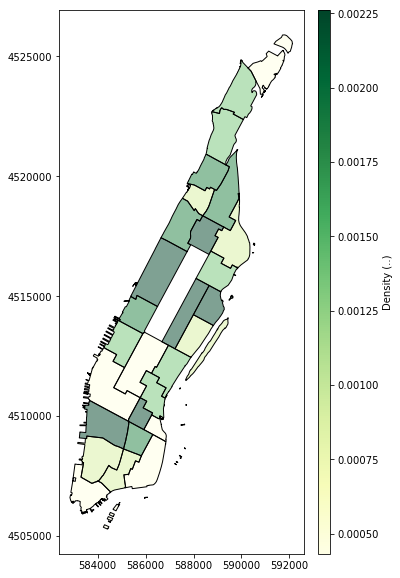

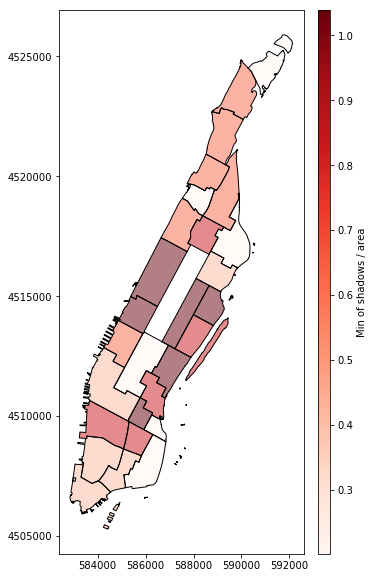

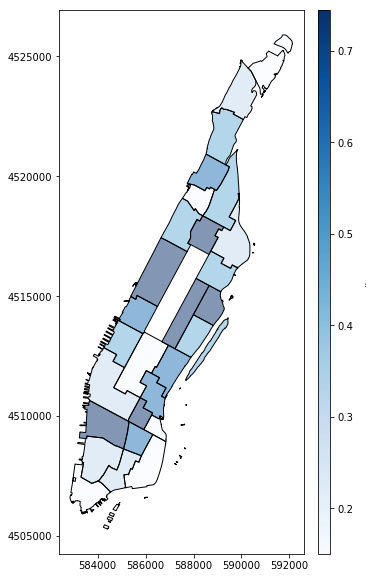

In [39]:
def plot(df, column, cmap='YlGn', label=''):
    
    fig, ax = plt.subplots()
    
    kw = dict(column=column, k=10, colormap=cmap)
    
    min_ = df[column].min()
    max_ = df[column].max()
    
    ax.set_aspect('equal')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_, vmax=max_))

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(plt.gca())

    cax = divider.append_axes("right", "5%", pad="6%")

    sm._A = []
    fig.colorbar(sm, cax=cax, orientation='vertical', label=label)
    
    df.plot(ax=ax,scheme='QUANTILES', **kw)
    
plot(villages, 'density', label='Density (..)') 
plot(villages, 'shadow_summer', cmap='Reds', label='Min of shadows / area') 
plot(villages, 'shadow_winter', cmap='Blues', label='..') 

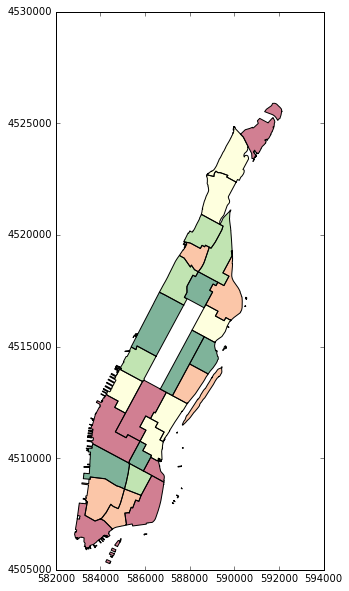

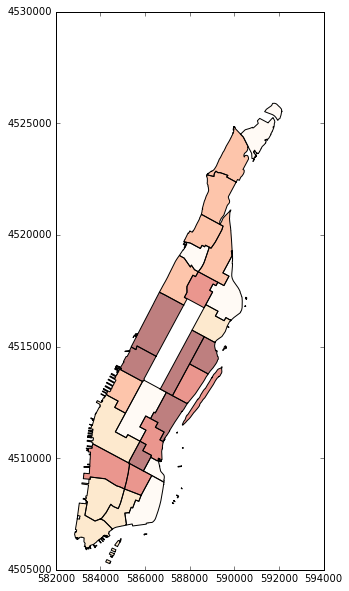

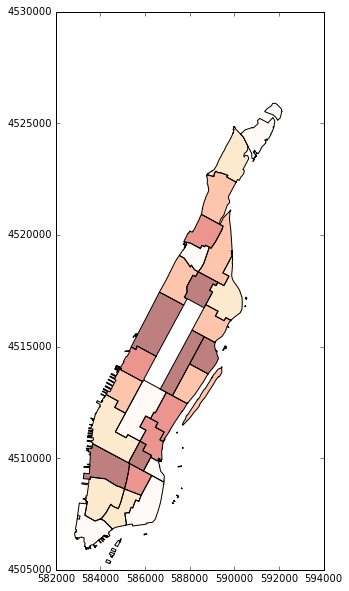

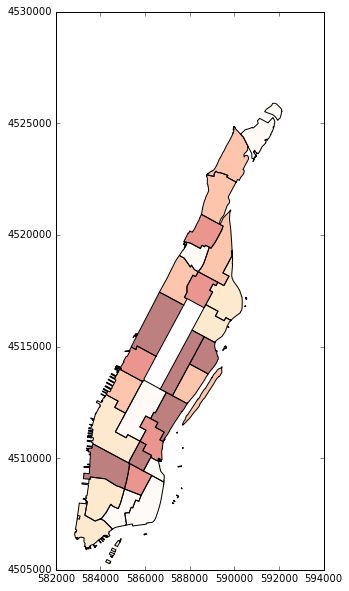

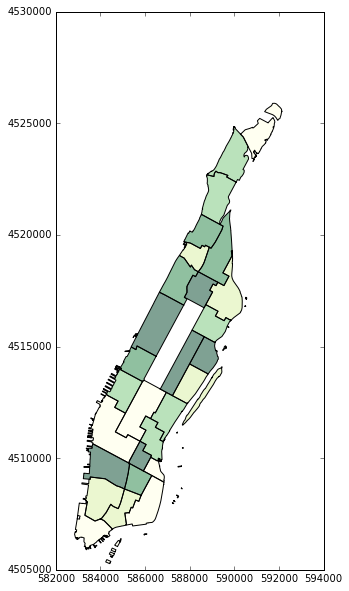

In [202]:
kw = dict(column='tree_score', k=10, colormap='RdYlGn')
villages.plot(scheme='QUANTILES', **kw)

kw = dict(column='shadow_summer', k=10, colormap='OrRd')
villages.plot(scheme='QUANTILES', **kw)

kw = dict(column='shadow_winter', k=10, colormap='OrRd')
villages.plot(scheme='QUANTILES', **kw)

kw = dict(column='shadow_fall', k=10, colormap='OrRd')
villages.plot(scheme='QUANTILES', **kw)

kw = dict(column='density', k=10, colormap='YlGn')
villages.plot(scheme='QUANTILES', **kw)

### .. now, look at the average height of the trees .. 
* check Central Park again!

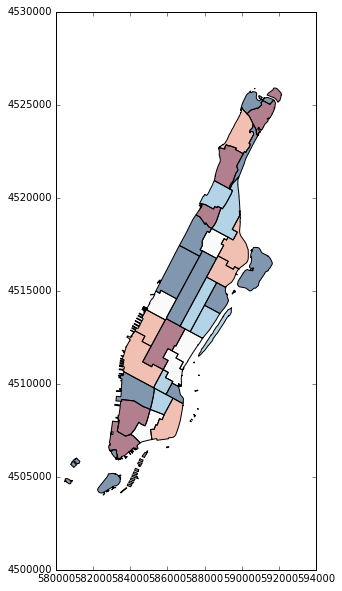

In [109]:
kw = dict(column='height_mean', k=10, colormap='RdBu')
villages.plot(scheme='QUANTILES', **kw)

In [30]:
df = pd.read_csv('data/health.csv', sep='\t')

In [210]:
import seaborn as sns

villages.corr()

,BoroCode,Shape_Area,Shape_Leng,count,density,tree_total,tree_score,shadow_summer,shadow_winter,shadow_fall,height_mean
BoroCode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shape_Area,NaN,1.000000,0.687387,0.650359,-0.145692,0.650359,-0.145692,-0.075089,-0.095571,-0.056537,-0.247890
Shape_Leng,NaN,0.687387,1.000000,0.274757,-0.359095,0.274757,-0.359095,-0.216622,-0.267501,-0.207350,-0.371412
count,NaN,0.650359,0.274757,1.000000,0.607294,1.000000,0.607294,0.555796,0.587899,0.586421,0.358523
density,NaN,-0.145692,-0.359095,0.607294,1.000000,0.607294,1.000000,0.895006,0.955747,0.914491,0.619875
tree_total,NaN,0.650359,0.274757,1.000000,0.607294,1.000000,0.607294,0.555796,0.587899,0.586421,0.358523
tree_score,NaN,-0.145692,-0.359095,0.607294,1.000000,0.607294,1.000000,0.895006,0.955747,0.914491,0.619875
shadow_summer,NaN,-0.075089,-0.216622,0.555796,0.895006,0.555796,0.895006,1.000000,0.977392,0.994565,0.477938
shadow_winter,NaN,-0.095571,-0.267501,0.587899,0.955747,0.587899,0.955747,0.977392,1.000000,0.987546,0.542448
shadow_fall,NaN,-0.056537,-0.207350,0.586421,0.914491,0.586421,0.914491,0.994565,0.987546,1.000000,0.490688
